<a href="https://colab.research.google.com/github/sorengod/MasterThesis/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsolutePercentageError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, Dropout

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot, dates
import datetime as dt
import statsmodels.api as sm

#EDA Class

In [ ]:
class Time_Series:

    def __init__ (self, df:pd.DataFrame, DateColumn='HourDK'):
        self.DateColumn = 'HourDK'
        self.df = df
        #self.df.set_index('HourDK')

    def extract_date_columns(self):
        #self.df = self.df.set_index(self.DateColumn)
        self.df['Year'] = self.df[self.DateColumn].dt.year
        self.df['Month'] = self.df[self.DateColumn].dt.month
        self.df['Date'] = self.df[self.DateColumn].dt.date
        self.df['Day_Of_Week'] = self.df[self.DateColumn].dt.strftime('%A')
        self.df.set_index('HourDK')
        return self.df
    
    def plot_prices(self, PriceAreas = []):
      self.df = self.df.set_index(self.DateColumn)
      self.df = self.df
      for PriceArea in PriceAreas:
        self.df.plot(y=PriceArea, use_index=True, figsize=(25,4), linewidth='.5', color = 'k')
    
    def plot_resample(self, Period:str, PriceAreas = []):
      help_df = self.df
      #help_df = help_df.set_index(self.DateColumn)
      for PriceArea in PriceAreas:
        plot_data = pd.DataFrame(data=help_df, columns =[PriceArea])
        plot_data.resample(Period).mean().plot(y=PriceArea, use_index=True, figsize=(25,2), linewidth='.5', color = 'k')
    
    def _group_by_hour(self, PriceArea):

      help_df = self.df[[self.DateColumn, PriceArea]]
      help_df.set_index(self.DateColumn, inplace=True)

      dates = help_df.index
      prices = help_df.values.tolist()
      dates_price_df = pd.Series(prices, index=dates)

      # Group prices by hour
      grouped = dates_price_df.groupby(dates_price_df.index.hour).apply(list)

      return grouped
    
    def plot_grouped_period(self, PriceArea):
      grouped_prices = self._group_by_hour(PriceArea)
      x = 6
      y = 3
      fig, axs = pyplot.subplots(x, y)      

      for period in range(len(grouped_prices)): 

        series = pd.DataFrame(grouped_prices[period])[:200]
        series.columns = [f'Period{period}']
        series.plot(y=f'Period{period}', use_index=True, figsize=(8,5), linewidth='.5', color = 'k')
      
      #return grouped_prices

object = Time_Series(abt)

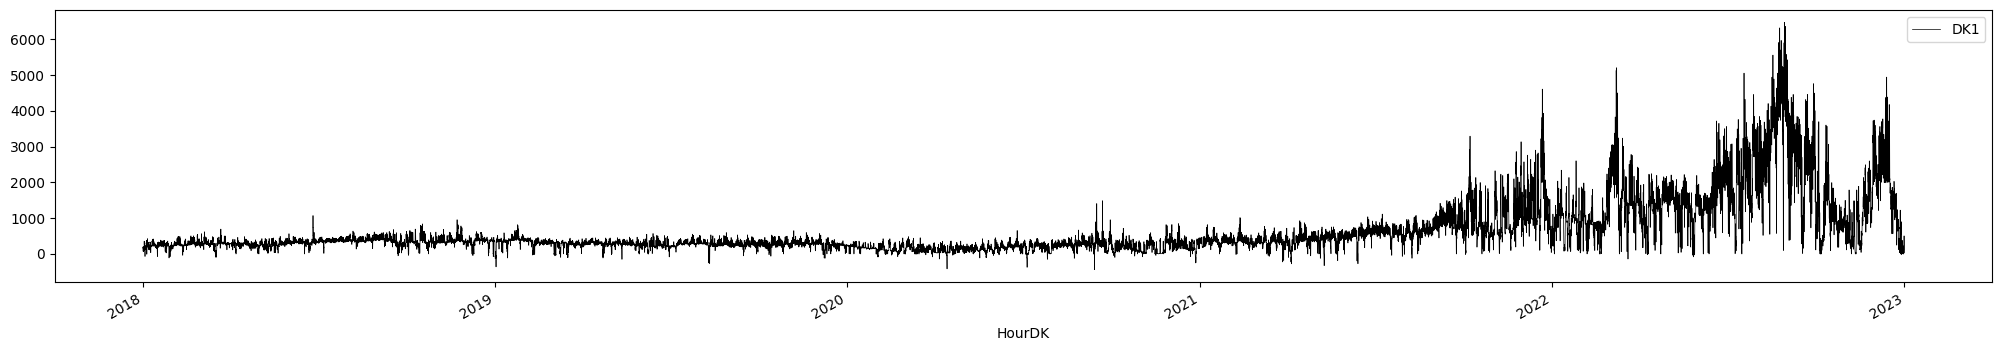

In [ ]:
object.plot_prices(['DK1'])

#So it Begins

In [ ]:
abt = pd.read_pickle("abt_new.pkl")
abt["wind_Gedser"] = abt["wind_Gedser"].fillna(method='ffill')
abt["wind_Anholdt"] = abt["wind_Gedser"].fillna(method='ffill')
abt["wind_Køge"] = abt["wind_Gedser"].fillna(method='ffill')
abt["wind_Blåvand"] = abt["wind_Gedser"].fillna(method='ffill')

abt["temp_Koebenhavn"] = abt["temp_Koebenhavn"].fillna(method='ffill')
abt["temp_Soenderbrog"] = abt["temp_Soenderbrog"].fillna(method='ffill')
abt["temp_Aarhus"] = abt["temp_Aarhus"].fillna(method='ffill')



In [ ]:

timestamp_s = abt['HourDK'].apply(lambda x: (x - datetime.datetime(2018, 1, 1)).total_seconds())
day = 24 * 60 * 60
abt['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
abt['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
abt = abt.drop(['HourDK'], axis=1) 



In [ ]:
abt.columns

Index(['DK1', 'DK2', 'NO2', 'SE3', 'SE4', 'OffshoreWindLt100MW_MWh',
       'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh',
       'OnshoreWindGe50kW_MWh', 'HydroPowerMWh', 'SolarPowerLt10kW_MWh',
       'ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh',
       'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'temp_Koebenhavn',
       'temp_Soenderbrog', 'temp_Aarhus', 'wind_Gedser', 'wind_Anholdt',
       'wind_Blåvand', 'wind_Køge', 'month', 'day', 'day_sin', 'day_cos',
       'Production_Coal_MWh', 'Production_BioGas_MWh',
       'Production_FossilGas_MWh', 'Production_Waste_MWh',
       'ConsumerPriceIndex'],
      dtype='object')

In [ ]:
abt = abt[['DK1', 
           'DK2', 
           'NO2', 'SE3', 'SE4',
           'OffshoreWindLt100MW_MWh',
       'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh',
       'OnshoreWindGe50kW_MWh', 'HydroPowerMWh', 'SolarPowerLt10kW_MWh', 'ExchangeNO_MWh',
       'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh',
       'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh','temp_Koebenhavn',
       'temp_Soenderbrog', 'temp_Aarhus', 'wind_Gedser', 'wind_Anholdt',
       'wind_Blåvand', 'wind_Køge','month', 'day',
       'day_sin', 'day_cos', 
       #'Production_Coal_MWh', 'Production_BioGas_MWh','Production_FossilGas_MWh', 'Production_Waste_MWh',
       'ConsumerPriceIndex_y'
       ]]

#Prepare 

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select the columns you want to normalize
columns_to_normalize = abt.columns.to_list()

test = abt

# Normalize the selected columns
abt[columns_to_normalize] = scaler.fit_transform(abt[columns_to_normalize])


In [ ]:
round(len(abt)*0.9)

40127

In [ ]:
train_df = abt[1:35669:]
val_df = abt[35669:40127:]
test_df = abt[40127::]

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(35668, 29) (4458, 29) (4459, 29)


In [ ]:
len(abt)

44586

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

---
#Create Data Windows

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_df['DK1'], color='black', linewidth=.5)  # Set the color to black
ax.set_xlabel('Time')
ax.set_ylabel('Spot Price')
plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 
'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 
'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
'Saturday', 'Sunday'])
plt.figsize=(15,1)
plt.xlim(0, 400)
plt.ylim(-50, 500)
fig.autofmt_xdate()
plt.plot()


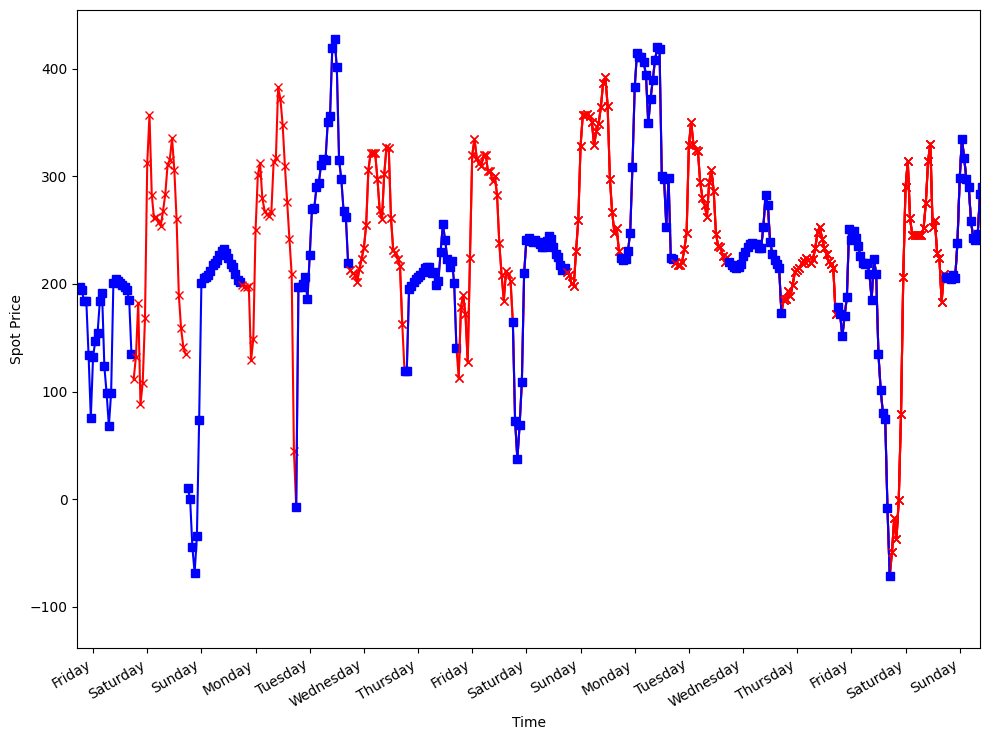

In [ ]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.DK1[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.DK1[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Spot Price')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH13_F01_peixeiro.png', dpi=300)

---
#Data Window Class

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def get_all_predictions(self, model):
      inputs, labels = self.sample_batch

      labels_to_convert = labels
      array = labels_to_convert.numpy()
      reshaped_array = array.reshape(-1, 1)

      df_predictions = pd.DataFrame(reshaped_array, columns=['Lables'])

      return df_predictions


    def get_all_actuals(self, model):
      inputs, labels = self.sample_batch

      df_Inputs = pd.DataFrame(inputs.numpy().reshape(-1, inputs.shape[-1]), columns=self.train_df.columns)

      return df_Inputs
    
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def df(self, model=None, plot_col='DK1', max_subplots=3):
        inputs, labels = self.sample_batch
        
        input_dfs = []
        label_dfs = []
        prediction_dfs = []
        
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            input_df = pd.DataFrame(inputs[n, :, :], columns=self.train_df.columns)
            input_dfs.append(input_df)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is not None:
                label_df = pd.DataFrame(labels[n, :, label_col_index], columns=['Labels'])
                label_dfs.append(label_df)
            
            if model is not None:
                predictions = model(inputs)
                prediction_df = pd.DataFrame(predictions[n, :, label_col_index], columns=['Predictions'])
                prediction_dfs.append(prediction_df)
        test_df = pd.concat(label_dfs + prediction_dfs, axis=1)
        return test_df
    
    def plot(self, model=None, plot_col='DK1', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
      
    
    
      

    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result


In [ ]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['DK1']) 

wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['DK1'])

multi_window = DataWindow(input_width=24, label_width=24, shift=48, label_columns=['DK1'])

val_performance = {}

ms_val_performance = {}

performance = {}

ms_performance = {}

column_indices = {name: i for i, name in enumerate(train_df.columns)}


def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

---
# Create Multistep Baseline Model


In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=48, label_columns=['DK1'])


ms_baseline_repeat = RepeatBaseline(label_index=column_indices['DK1'])

test = ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)



138/138 [==============================] - 0s 2ms/step - loss: 1969299.5000 - mean_absolute_error: 1175.1190


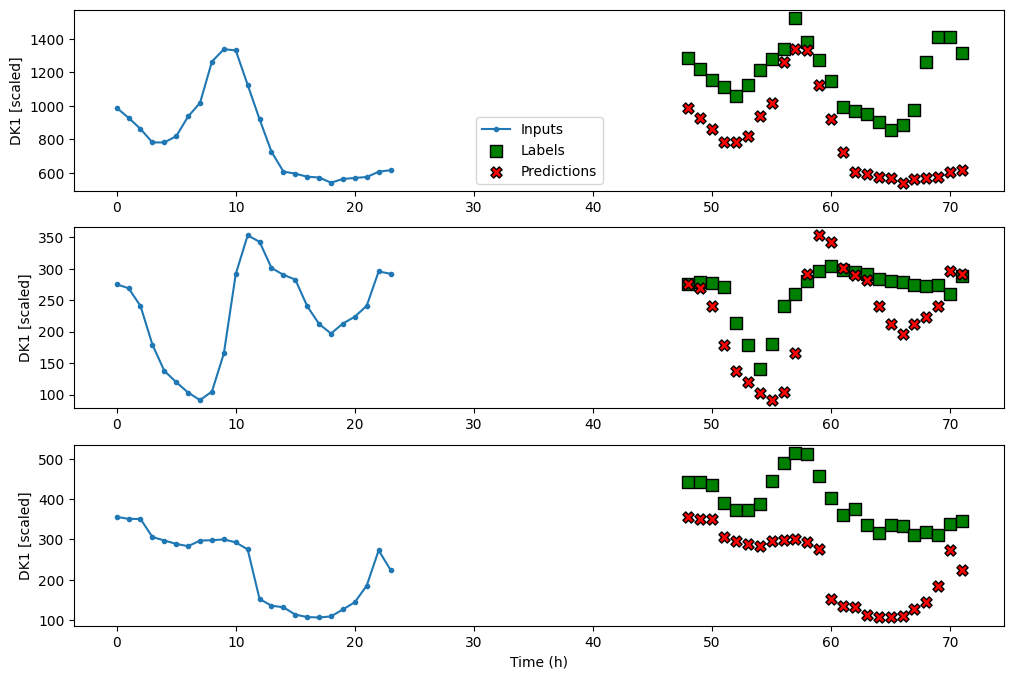

In [ ]:
multi_window.plot(ms_baseline_repeat)

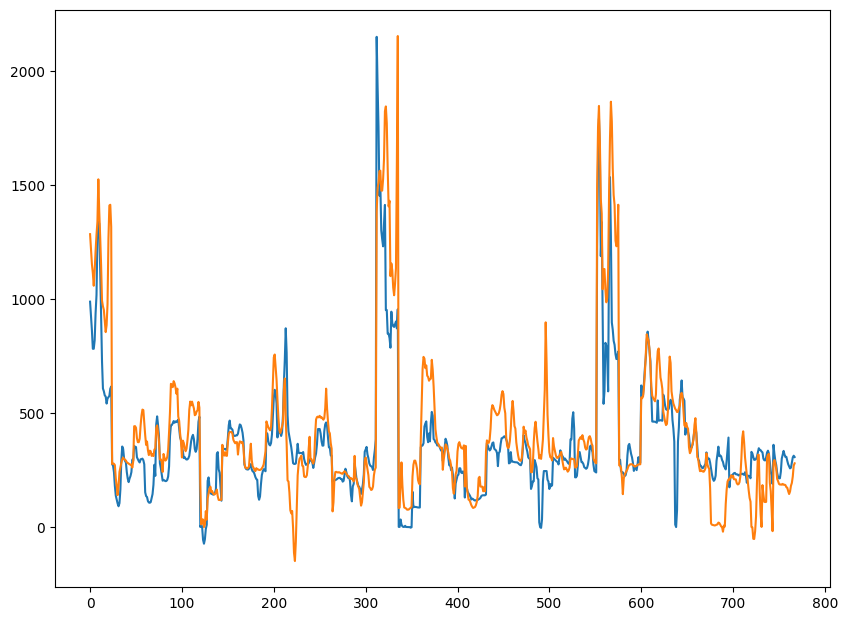

In [ ]:
test = multi_window.df(ms_baseline_repeat)

actuals = multi_window.get_all_actuals(ms_baseline_repeat)["DK1"].reset_index()
predictions = multi_window.get_all_predictions(ms_baseline_repeat).reset_index()
test = predictions.merge(actuals, left_on="index", right_on="index")
test["Error"] = test["Lables"] - test["DK1"]
test = predictions.merge(actuals, left_on="index", right_on="index")
test["Error"] = test["Lables"] - test["DK1"]
plt.plot(test["index"], test[["DK1", "Lables"]])


---
# Single step linear model

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [ ]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window.plot(linear)


In [ ]:
val_performance

{'Baseline - Last': [30936.00390625, 106.43860626220703],
 'Linear': [32342.126953125, 111.2458724975586]}

---
#Multistep Linear model

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=48, label_columns=['DK1'])

ms_linear = Sequential([
    Dense(32, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(ms_linear)

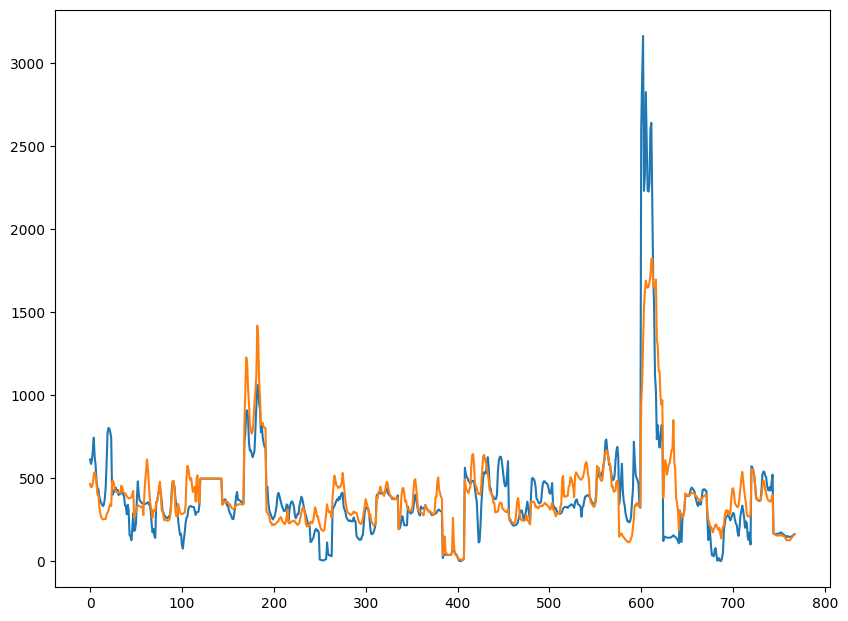

In [ ]:
test = multi_window.df(ms_linear)

actuals = multi_window.get_all_actuals(ms_baseline_repeat)["DK1"].reset_index()
predictions = multi_window.get_all_predictions(ms_baseline_repeat).reset_index()
test = predictions.merge(actuals, left_on="index", right_on="index")
test["Error"] = test["Lables"] - test["DK1"]
test = predictions.merge(actuals, left_on="index", right_on="index")
test["Error"] = test["Lables"] - test["DK1"]
plt.plot(test["index"], test[["DK1", "Lables"]])

In [ ]:
test

,index,Lables,DK1,Error
0,0,465.070007,612.099976,-147.029968
1,1,446.260010,584.799988,-138.539978
2,2,446.260010,606.739990,-160.479980
3,3,466.929993,667.070007,-200.140015
4,4,520.039978,743.159973,-223.119995
...,...,...,...,...
763,763,134.220001,145.190002,-10.970001
764,764,142.289993,149.380005,-7.090012
765,765,148.940002,153.860001,-4.919998
766,766,156.259995,160.059998,-3.800003


---
#Deep Learning Model


In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=48, label_columns=['DK1'])


dense = Sequential([
    Dense(units=64, activation='relu'),
    Dropout(0.2),  # Add dropout with a rate of 0.2
    Dense(units=32, activation='sigmoid'),
    Dropout(0.2),  # Add dropout with a rate of 0.2
    Dense(units=16, activation='sigmoid'),
    Dropout(0.2),  # Add dropout with a rate of 0.2
    Dense(units=1)
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(dense)

In [ ]:
actuals = multi_window.get_all_actuals(dense)["DK1"].reset_index()
predictions = multi_window.get_all_predictions(dense).reset_index()
test = predictions.merge(actuals, left_on="index", right_on="index")
test["Error"] = test["Lables"] - test["DK1"]
test = predictions.merge(actuals, left_on="index", right_on="index")
test["Error"] = test["Lables"] - test["DK1"]
plt.plot(test["index"], test[["DK1", "Lables"]])

#RNN

In [ ]:
ms_performance = {}
ms_val_performance = {}

ms_val_performance['Baseline - Repeat'] = 348.56
ms_performance['Baseline - Repeat'] = 400

ms_val_performance['Baseline - Linear NN'] = 200
ms_performance['Baseline - Linear NN'] = 220

ms_val_performance['Dense'] = 150
ms_performance['Dense'] = 179

ms_val_performance['RNN'] = 100
ms_performance['RNN'] = 110

ms_val_performance['LSTM'] = 50
ms_performance['LSTM'] = 60

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

val_performance = {'Baseline - Repeat': 348.56,
                   'Baseline - Linear NN': 200,
                   'Dense': 150,
                   'RNN': 100,
                   'LSTM': 50}

performance = {'Baseline - Repeat': 400,
               'Baseline - Linear NN': 220,
               'Dense': 179,
               'RNN': 110,
               'LSTM': 60}

models = list(val_performance.keys())
val_errors = list(val_performance.values())
test_errors = list(performance.values())

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, val_errors, width, label='Validation')
rects2 = ax.bar(x + width/2, test_errors, width, label='Test')

ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


In [ ]:
ms_val_performance

{'Baseline - Repeat': 348.56,
 'Baseline - Linear NN': 348.56,
 'Dense': 348.56,
 'RNN': 348.56,
 'LSTM': 348.56}

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 500)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

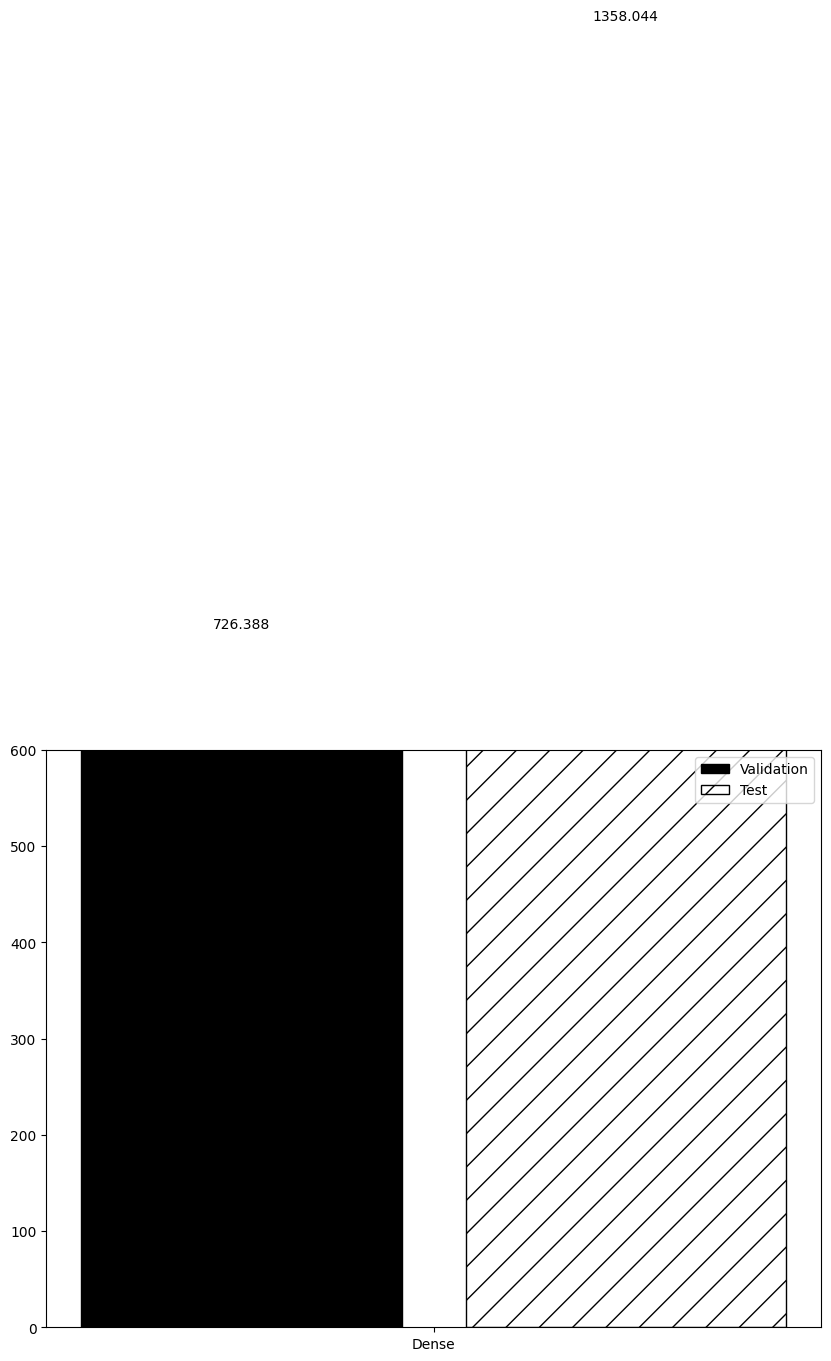

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
  
plt.ylim(0, 600)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

---
#Multi step Deep Learning Model

In [ ]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

#LSTM

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=48, label_columns=['DK1'])

from keras.layers import Dropout

lstm_model = Sequential([
    LSTM(64, return_sequences=True),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, multi_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)



